# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In this project I will be trying to understand which factors will be affecting the used car price the most. In order to get the bested results we will be focusing on the factors such as the year the car was sold and how many miles are on the odometer (Numerical factors). 

In [15]:
#Importing in the required packages for this project 
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [16]:
#Import in the data file and understand the different columns 
car = pd.read_csv("data/vehicles.csv")
car.head()


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [17]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [18]:
#Cleaning the data will require dropping all NaN rows as well as any other information
#we do not need like non-numerical data
df = car.dropna()
df = df[df['price'] != 0]

In [19]:
df.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [32]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al


In [22]:
#Creating train and test var
X = df.drop(['id', 'region', 'price', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'], axis= 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)



### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [24]:
#Training and predict 

#Creating a pipeline
pipe = Pipeline([
    ('pfeat', PolynomialFeatures(degree=2, include_bias=False)), 
    ('linreg', LinearRegression())
])
#Fit the model
train_preds = pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

TypeError: __init__() got an unexpected keyword argument 'random_state'

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [29]:
#Get the mean squared error for both 
train_mses = mean_squared_error(y_train, train_preds)
test_mses = mean_squared_error(y_test, test_preds)


print(f"Training mean squared: ", train_mses)
print(f"Test mean squared: ", test_mses)

Training mean squared:  140997280.34569517
Test mean squared:  146230138.83860663


In [38]:
#Getting the permutation importance value
per_impor = permutation_importance(pipe, X_test, y_test)
importance = pd.DataFrame(data = per_impor.importances_mean, index= X.columns, columns=['Permutation Importance']).sort_values(by = 'Permutation Importance', ascending=False)
importance

,Permutation Importance
odometer,0.181851
year,0.099891


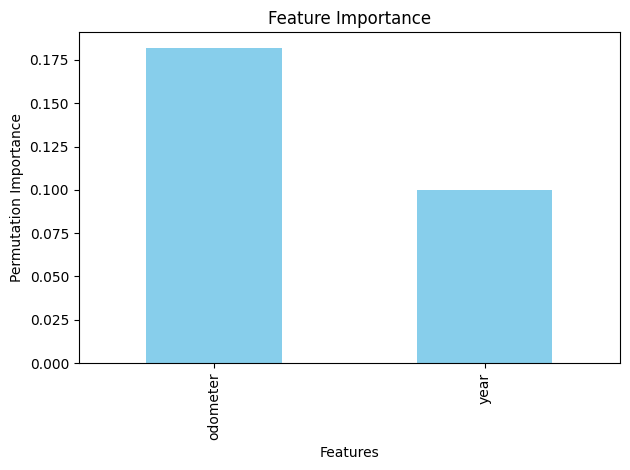

In [39]:
importance.plot(kind='bar', legend=False, color='skyblue', title='Feature Importance')
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.tight_layout()
plt.show()

In [37]:
#Lets now take a look at the correlation between the features and their coefficients 
coef = pipe.named_steps['linreg'].coef_
lin_df = pd.DataFrame({'Features': pipe.named_steps['pfeat'].get_feature_names_out(), 'Coeffiecients': coef})
lin_df

,Features,Coeffiecients
0,year,2.251851e-05
1,odometer,-2.974064e-01
2,year^2,9.911465e-02
3,year odometer,1.154152e-04
4,odometer^2,6.983489e-09


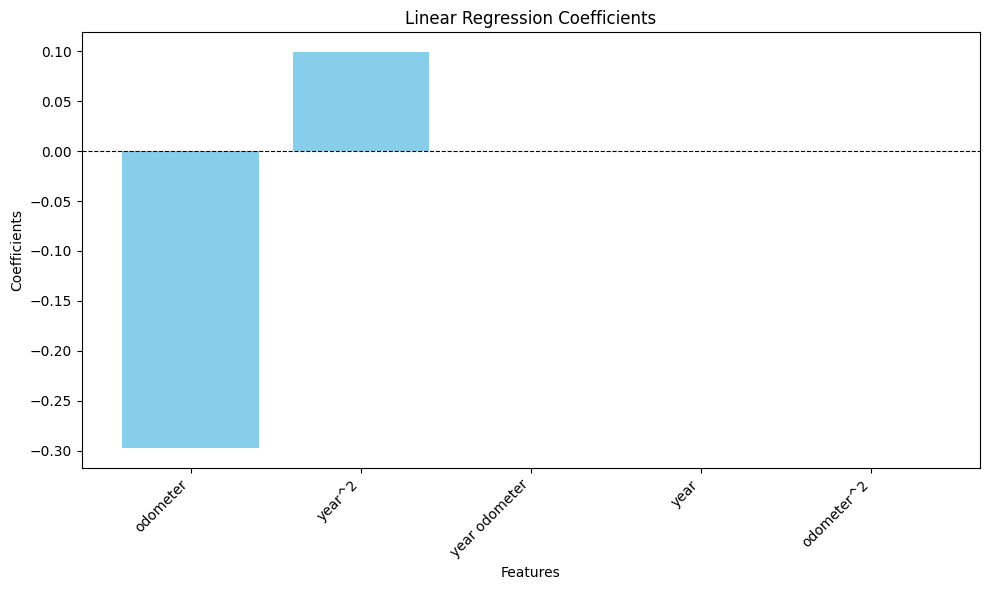

,Features,Coefficients
1,odometer,-2.974064e-01
2,year^2,9.911465e-02
3,year odometer,1.154152e-04
0,year,2.251851e-05
4,odometer^2,6.983489e-09


In [48]:

# Sort by the absolute value of coefficients for better visualization
lin_df = lin_df.reindex(lin_df['Coefficients'].abs().sort_values(ascending=False).index)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(lin_df['Features'], lin_df['Coefficients'], color='skyblue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at 0
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Linear Regression Coefficients')
plt.tight_layout()  # Adjust layout
plt.show()

# Display the DataFrame for reference
lin_df

5 5


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Through this model we can clearly tell that the odometer has the most impact on the price of the vehicle. While odometer has more of an impact than the year of the car, from our coeffie